# Data Processing for Rice Production Forecasting

This notebook processes rice production data from 2018-2024 for Indonesian provinces.
The data includes:
- Luas Panen (Harvested Area) in hectares
- Produktivitas (Productivity) in ku/ha (quintal per hectare)
- Produksi (Production) in tons


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Exploration

In [2]:
# Define data directory
data_dir = "data/"

# Get all CSV files
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
csv_files.sort()

print(f"Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"- {os.path.basename(file)}")

Found 7 CSV files:
- Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2018.csv
- Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2019.csv
- Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2020.csv
- Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2021.csv
- Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2022.csv
- Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2023.csv
- Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2024.csv


In [3]:
def load_and_clean_csv(file_path):
    """
    Load and clean a single CSV file
    """
    # Extract year from filename
    year = int(os.path.basename(file_path).split(', ')[-1].split('.')[0])
    
    # Read CSV, skipping the header rows
    df = pd.read_csv(file_path, skiprows=3)
    
    # Clean column names
    df.columns = ['Province', 'Luas_Panen_ha', 'Produktivitas_ku_ha', 'Produksi_ton']
    
    # Remove rows with missing province names
    df = df.dropna(subset=['Province'])
    
    # Clean province names (remove extra spaces)
    df['Province'] = df['Province'].str.strip()
    
    # Add year column
    df['Year'] = year
    
    # Convert numeric columns to float, handling any string values
    numeric_cols = ['Luas_Panen_ha', 'Produktivitas_ku_ha', 'Produksi_ton']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

# Load all data files
all_data = []
for file in csv_files:
    try:
        df = load_and_clean_csv(file)
        all_data.append(df)
        print(f"Loaded {file}: {len(df)} provinces")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine all data
combined_df = pd.concat(all_data, ignore_index=True)
print(f"\nTotal combined data shape: {combined_df.shape}")

Loaded data\Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2018.csv: 39 provinces
Loaded data\Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2019.csv: 39 provinces
Loaded data\Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2020.csv: 39 provinces
Loaded data\Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2021.csv: 39 provinces
Loaded data\Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2022.csv: 39 provinces
Loaded data\Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2023.csv: 39 provinces
Loaded data\Luas Panen, Produksi, dan Produktivitas Padi Menurut Provinsi, 2024.csv: 39 provinces

Total combined data shape: (273, 5)


In [4]:
# Display basic information about the dataset
print("Dataset Info:")
print(combined_df.info())
print("\nFirst few rows:")
print(combined_df.head(10))
print("\nUnique years:")
print(sorted(combined_df['Year'].unique()))
print("\nNumber of provinces per year:")
print(combined_df.groupby('Year')['Province'].nunique())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Province             273 non-null    object 
 1   Luas_Panen_ha        253 non-null    float64
 2   Produktivitas_ku_ha  253 non-null    float64
 3   Produksi_ton         253 non-null    float64
 4   Year                 273 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 10.8+ KB
None

First few rows:
               Province  Luas_Panen_ha  Produktivitas_ku_ha  Produksi_ton  \
0                  ACEH      329515.78                56.49    1861567.10   
1        SUMATERA UTARA      408176.45                51.65    2108284.72   
2        SUMATERA BARAT      313050.82                47.37    1483076.48   
3                  RIAU       71448.08                37.28     266375.53   
4                 JAMBI       86202.68                44.44   

## 2. Data Quality Assessment

In [5]:
# Check for missing values
print("Missing values per column:")
print(combined_df.isnull().sum())
print("\nMissing values percentage:")
print((combined_df.isnull().sum() / len(combined_df)) * 100)

# Check for duplicate entries
duplicates = combined_df.duplicated(subset=['Province', 'Year']).sum()
print(f"\nDuplicate province-year combinations: {duplicates}")

if duplicates > 0:
    print("Duplicate entries:")
    print(combined_df[combined_df.duplicated(subset=['Province', 'Year'], keep=False)].sort_values(['Province', 'Year']))

Missing values per column:
Province                0
Luas_Panen_ha          20
Produktivitas_ku_ha    20
Produksi_ton           20
Year                    0
dtype: int64

Missing values percentage:
Province               0.000000
Luas_Panen_ha          7.326007
Produktivitas_ku_ha    7.326007
Produksi_ton           7.326007
Year                   0.000000
dtype: float64

Duplicate province-year combinations: 0


In [6]:
# Statistical summary
print("Statistical Summary:")
print(combined_df.describe())

# Check for outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

numeric_columns = ['Luas_Panen_ha', 'Produktivitas_ku_ha', 'Produksi_ton']
for col in numeric_columns:
    outliers = detect_outliers(combined_df, col)
    print(f"\nOutliers in {col}: {len(outliers)} records")
    if len(outliers) > 0 and len(outliers) <= 10:
        print(outliers[['Province', 'Year', col]].sort_values(col))

Statistical Summary:
       Luas_Panen_ha  Produktivitas_ku_ha  Produksi_ton         Year
count   2.530000e+02           253.000000  2.530000e+02   273.000000
mean    5.836949e+05            45.429289  3.041437e+06  2021.000000
std     1.746563e+06             8.550635  9.156600e+06     2.003673
min     9.660000e+00            26.530000  4.238000e+01  2018.000000
25%     4.900995e+04            39.690000  2.177896e+05  2019.000000
50%     1.109784e+05            46.200000  5.300291e+05  2021.000000
75%     3.178694e+05            51.640000  1.655170e+06  2023.000000
max     1.137793e+07            72.760000  5.920053e+07  2024.000000

Outliers in Luas_Panen_ha: 35 records

Outliers in Produktivitas_ku_ha: 1 records
       Province  Year  Produktivitas_ku_ha
10  DKI JAKARTA  2018                72.76

Outliers in Produksi_ton: 35 records


## 3. Data Cleaning and Preprocessing

In [7]:
# Create a clean copy of the data
clean_df = combined_df.copy()

# Handle missing values
print("Before cleaning - Missing values:")
print(clean_df.isnull().sum())

# Remove rows with missing critical data
initial_rows = len(clean_df)
clean_df = clean_df.dropna(subset=['Luas_Panen_ha', 'Produktivitas_ku_ha', 'Produksi_ton'])
print(f"\nRemoved {initial_rows - len(clean_df)} rows with missing values")

# Remove duplicate province-year combinations (keep first occurrence)
initial_rows = len(clean_df)
clean_df = clean_df.drop_duplicates(subset=['Province', 'Year'], keep='first')
print(f"Removed {initial_rows - len(clean_df)} duplicate entries")

print(f"\nFinal clean dataset shape: {clean_df.shape}")

Before cleaning - Missing values:
Province                0
Luas_Panen_ha          20
Produktivitas_ku_ha    20
Produksi_ton           20
Year                    0
dtype: int64

Removed 20 rows with missing values
Removed 0 duplicate entries

Final clean dataset shape: (253, 5)


In [8]:
# Standardize province names
province_mapping = {
    'DKI JAKARTA': 'JAKARTA',
    'DI YOGYAKARTA': 'YOGYAKARTA',
    'KEP. BANGKA BELITUNG': 'BANGKA BELITUNG',
    'KEP. RIAU': 'KEPULAUAN RIAU'
}

clean_df['Province'] = clean_df['Province'].replace(province_mapping)

# Drop Indonesia
clean_df = clean_df[clean_df['Province'] != 'INDONESIA']

# Create additional derived features
clean_df['Productivity_per_ton'] = clean_df['Produktivitas_ku_ha'] / 10  # Convert ku/ha to ton/ha
clean_df['Production_efficiency'] = clean_df['Produksi_ton'] / clean_df['Luas_Panen_ha']  # ton per hectare

print("Added derived features:")
print("- Productivity_per_ton: Productivity in ton/ha")
print("- Production_efficiency: Actual production per hectare")

print(f"\nUnique provinces: {clean_df['Province'].nunique()}")
print("\nProvince list:")
for i, province in enumerate(sorted(clean_df['Province'].unique()), 1):
    print(f"{i:2d}. {province}")

Added derived features:
- Productivity_per_ton: Productivity in ton/ha
- Production_efficiency: Actual production per hectare

Unique provinces: 38

Province list:
 1. ACEH
 2. BALI
 3. BANGKA BELITUNG
 4. BANTEN
 5. BENGKULU
 6. GORONTALO
 7. JAKARTA
 8. JAMBI
 9. JAWA BARAT
10. JAWA TENGAH
11. JAWA TIMUR
12. KALIMANTAN BARAT
13. KALIMANTAN SELATAN
14. KALIMANTAN TENGAH
15. KALIMANTAN TIMUR
16. KALIMANTAN UTARA
17. KEPULAUAN RIAU
18. LAMPUNG
19. MALUKU
20. MALUKU UTARA
21. NUSA TENGGARA BARAT
22. NUSA TENGGARA TIMUR
23. PAPUA
24. PAPUA BARAT
25. PAPUA BARAT DAYA
26. PAPUA PEGUNUNGAN
27. PAPUA SELATAN
28. PAPUA TENGAH
29. RIAU
30. SULAWESI BARAT
31. SULAWESI SELATAN
32. SULAWESI TENGAH
33. SULAWESI TENGGARA
34. SULAWESI UTARA
35. SUMATERA BARAT
36. SUMATERA SELATAN
37. SUMATERA UTARA
38. YOGYAKARTA


## 4. Exploratory Data Analysis

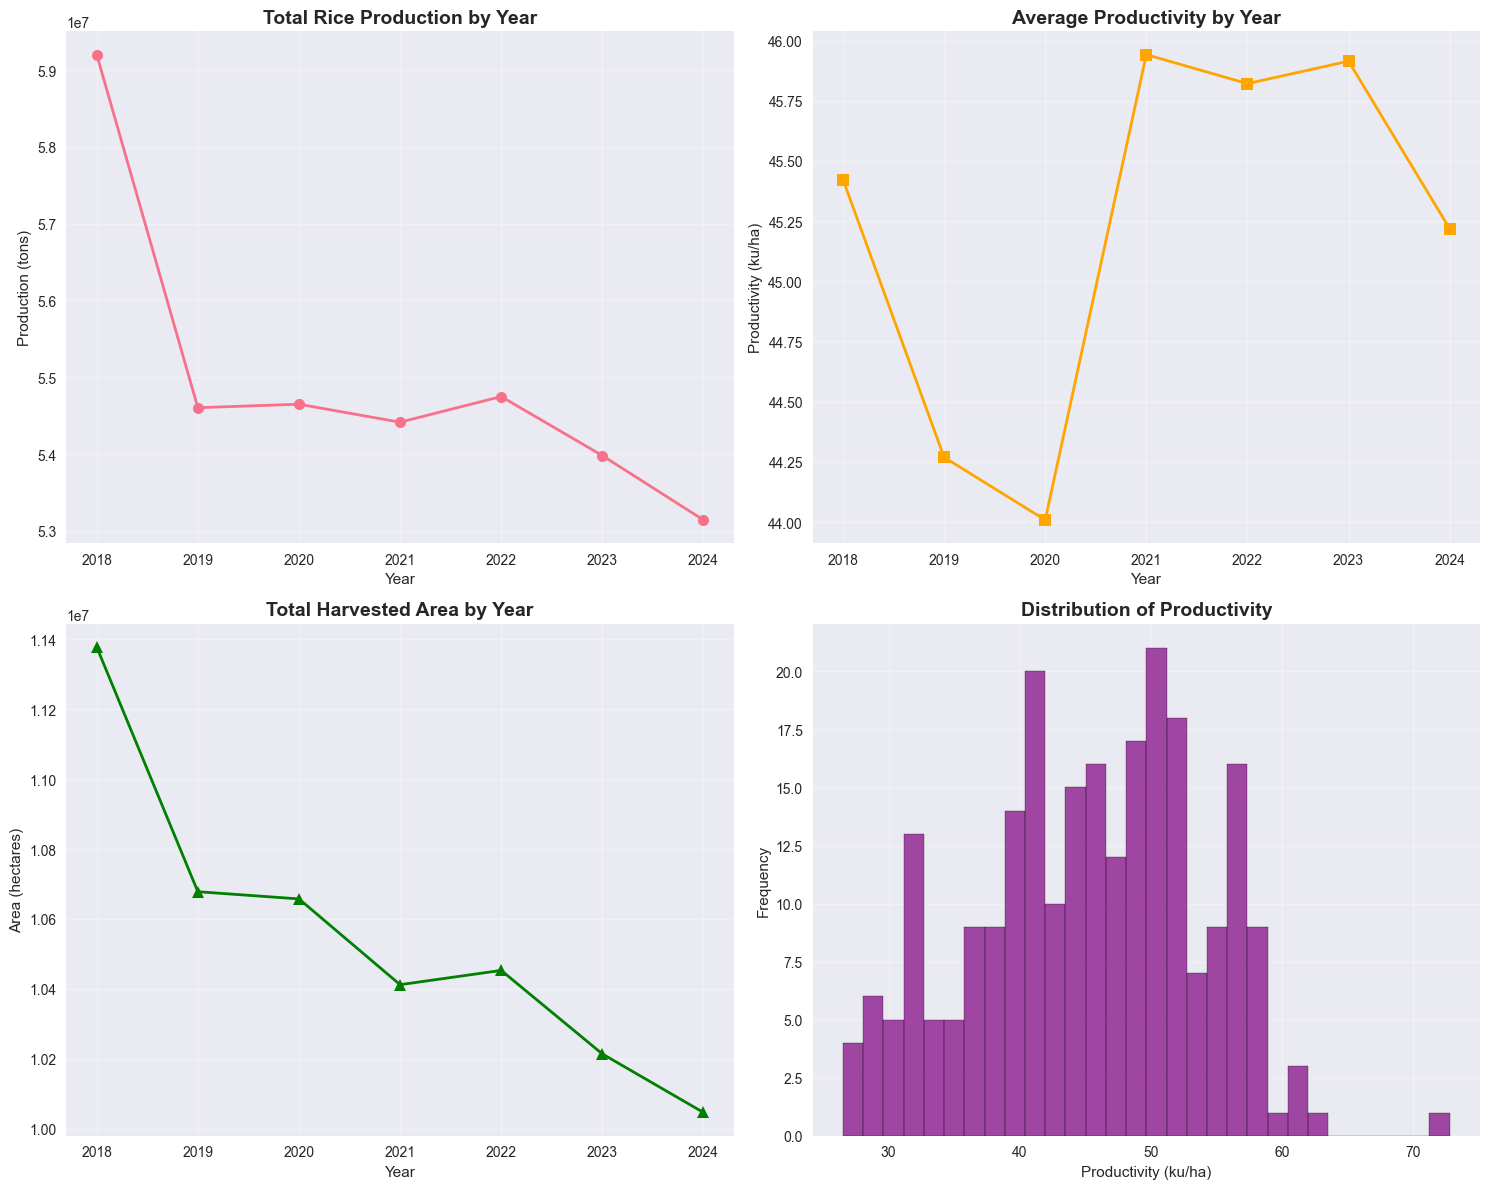

In [9]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Total production by year
yearly_production = clean_df.groupby('Year')['Produksi_ton'].sum()
axes[0, 0].plot(yearly_production.index, yearly_production.values, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_title('Total Rice Production by Year', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Production (tons)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Average productivity by year
yearly_productivity = clean_df.groupby('Year')['Produktivitas_ku_ha'].mean()
axes[0, 1].plot(yearly_productivity.index, yearly_productivity.values, marker='s', color='orange', linewidth=2, markersize=8)
axes[0, 1].set_title('Average Productivity by Year', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Productivity (ku/ha)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Total harvested area by year
yearly_area = clean_df.groupby('Year')['Luas_Panen_ha'].sum()
axes[1, 0].plot(yearly_area.index, yearly_area.values, marker='^', color='green', linewidth=2, markersize=8)
axes[1, 0].set_title('Total Harvested Area by Year', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Area (hectares)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of productivity
axes[1, 1].hist(clean_df['Produktivitas_ku_ha'], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('Distribution of Productivity', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Productivity (ku/ha)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

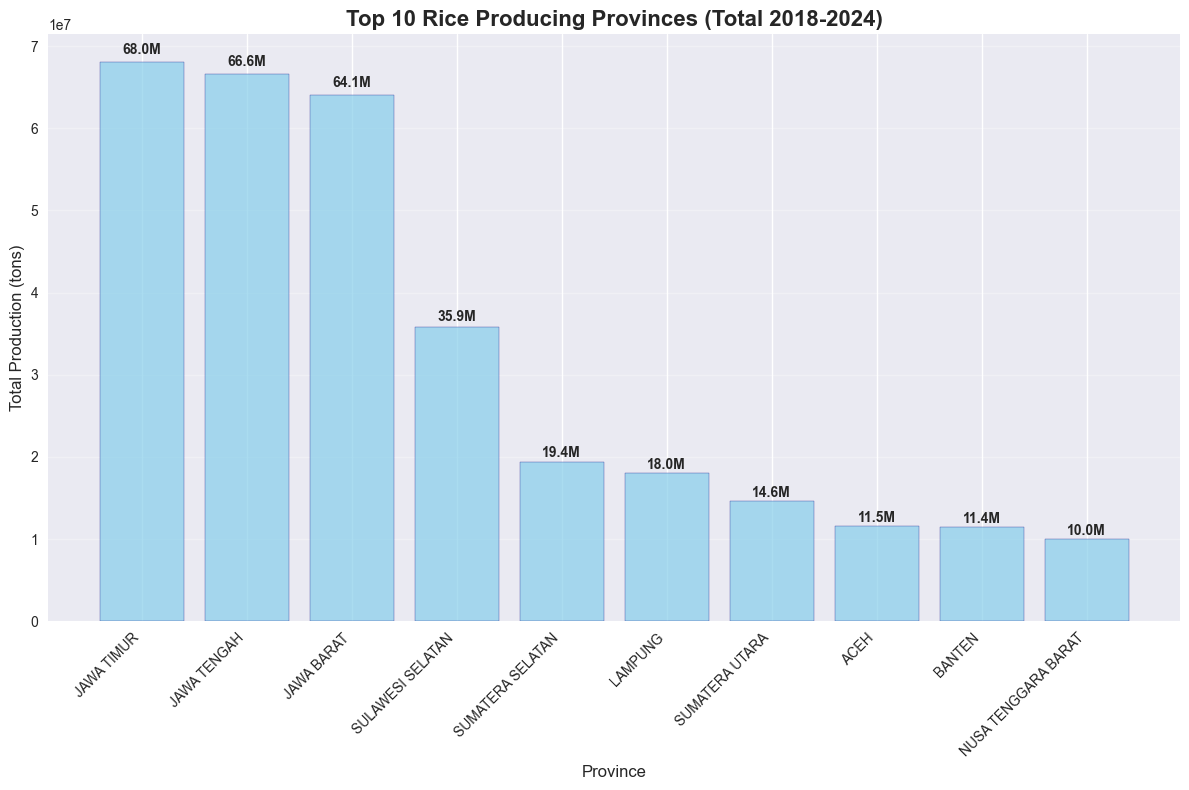

Top 10 Rice Producing Provinces (2018-2024):
 1. JAWA TIMUR          :   68,025,886 tons
 2. JAWA TENGAH         :   66,594,913 tons
 3. JAWA BARAT          :   64,063,304 tons
 4. SULAWESI SELATAN    :   35,860,870 tons
 5. SUMATERA SELATAN    :   19,410,346 tons
 6. LAMPUNG             :   18,025,879 tons
 7. SUMATERA UTARA      :   14,612,763 tons
 8. ACEH                :   11,541,614 tons
 9. BANTEN              :   11,442,393 tons
10. NUSA TENGGARA BARAT :   10,044,161 tons


In [10]:
# Top producing provinces analysis
top_producers = clean_df.groupby('Province')['Produksi_ton'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(top_producers)), top_producers.values, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Top 10 Rice Producing Provinces (Total 2018-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Province', fontsize=12)
plt.ylabel('Total Production (tons)', fontsize=12)
plt.xticks(range(len(top_producers)), top_producers.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height/1e6:.1f}M', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Top 10 Rice Producing Provinces (2018-2024):")
for i, (province, production) in enumerate(top_producers.items(), 1):
    print(f"{i:2d}. {province:<20}: {production:>12,.0f} tons")

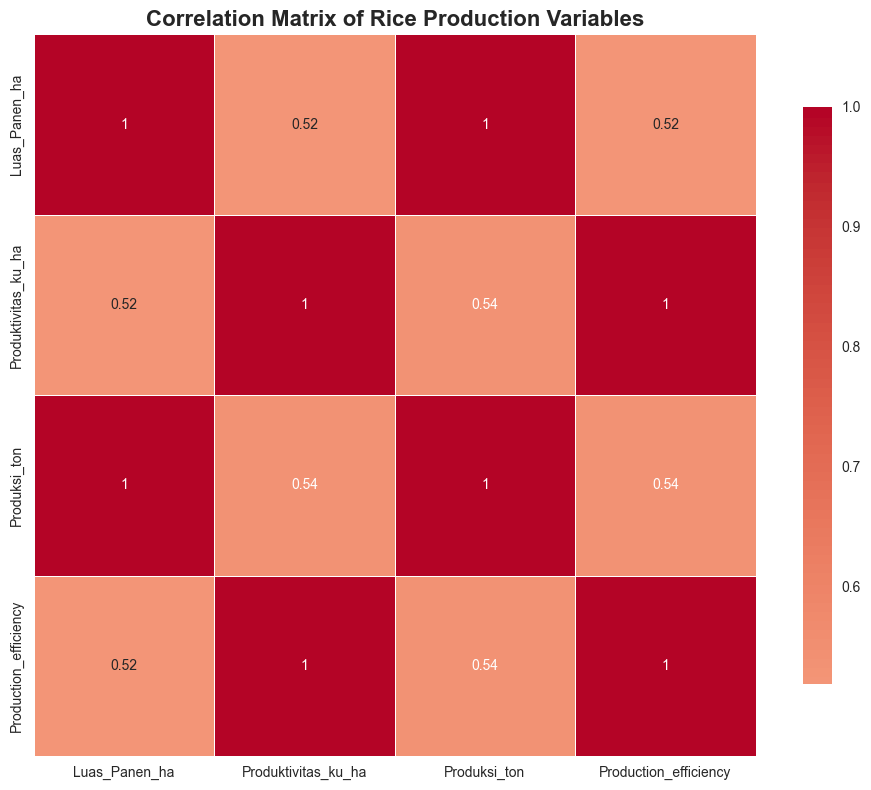

Key Correlations:
Area vs Production: 0.998
Productivity vs Production: 0.536
Area vs Productivity: 0.519


In [11]:
# Correlation analysis
correlation_cols = ['Luas_Panen_ha', 'Produktivitas_ku_ha', 'Produksi_ton', 'Production_efficiency']
correlation_matrix = clean_df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Rice Production Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key Correlations:")
print(f"Area vs Production: {correlation_matrix.loc['Luas_Panen_ha', 'Produksi_ton']:.3f}")
print(f"Productivity vs Production: {correlation_matrix.loc['Produktivitas_ku_ha', 'Produksi_ton']:.3f}")
print(f"Area vs Productivity: {correlation_matrix.loc['Luas_Panen_ha', 'Produktivitas_ku_ha']:.3f}")

## 5. Time Series Analysis Preparation

National Time Series Data:
   Year  Luas_Panen_ha  Produktivitas_ku_ha  Produksi_ton  Production_growth  \
0  2018    11377934.44            45.422353   59200533.72                NaN   
1  2019    10677887.15            44.269118   54604033.34          -7.764289   
2  2020    10657274.96            44.008824   54649202.24           0.082721   
3  2021    10411801.22            45.941471   54415294.22          -0.428017   
4  2022    10452672.35            45.820882   54748975.85           0.613213   
5  2023    10213705.17            45.914211   53980993.19          -1.402734   
6  2024    10046135.37            45.218421   53142726.65          -1.552892   

   Area_growth  Productivity_growth  
0          NaN                  NaN  
1    -6.152675            -2.538916  
2    -0.193036            -0.587981  
3    -2.303344             4.391499  
4     0.392546            -0.262482  
5    -2.286183             0.203680  
6    -1.640637            -1.515412  


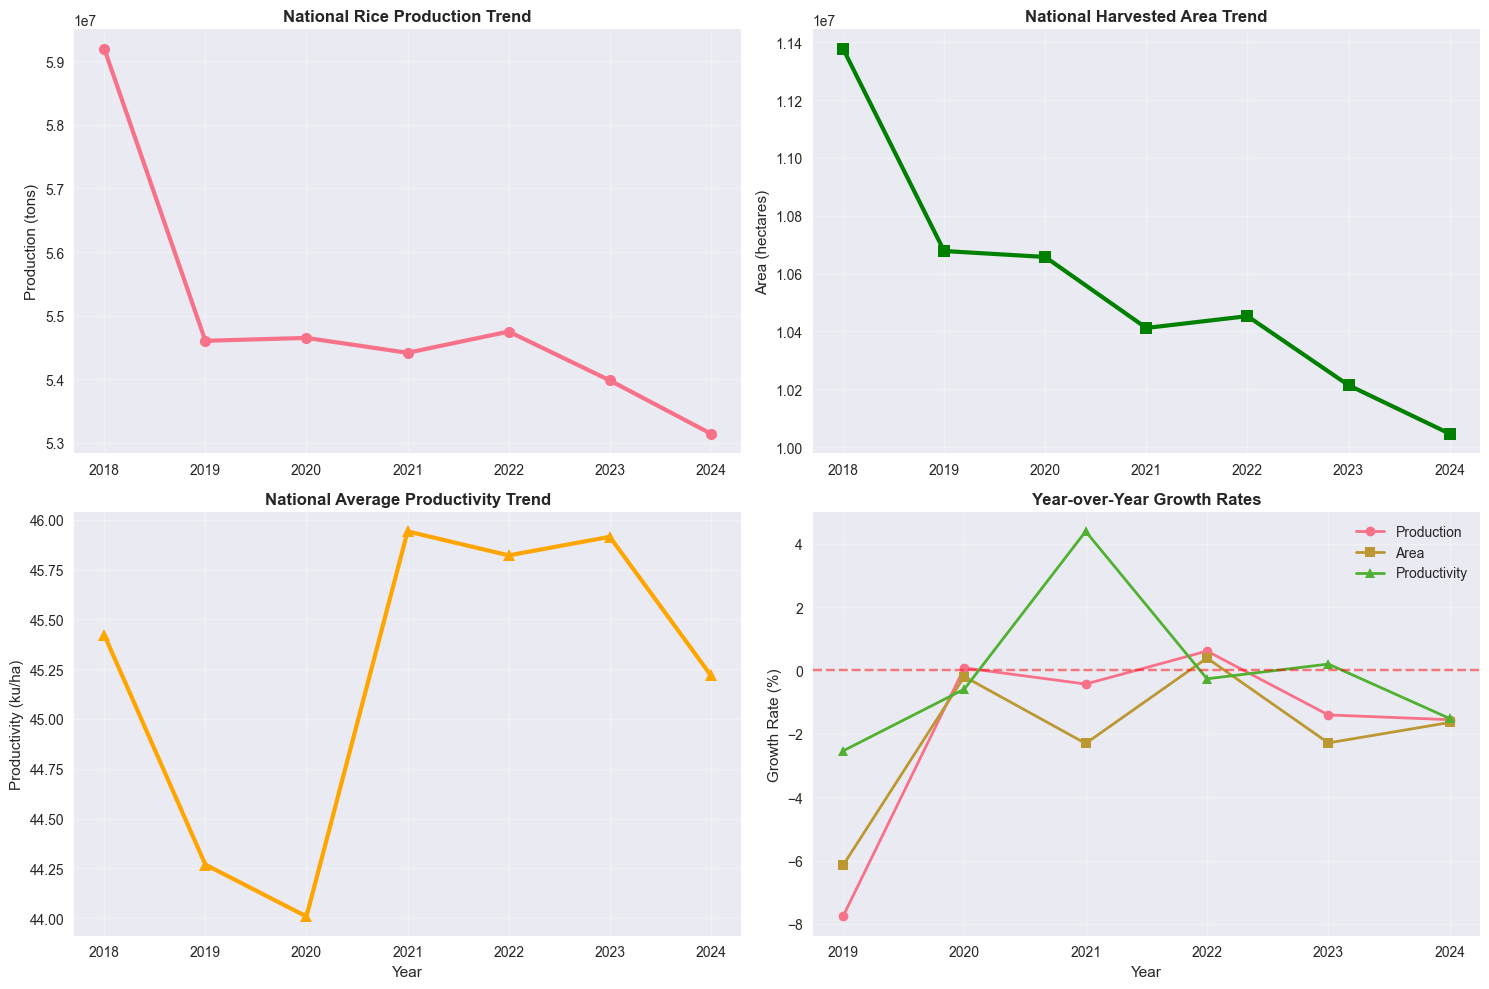

In [12]:
# Create time series data for forecasting
# Aggregate national level data
national_ts = clean_df.groupby('Year').agg({
    'Luas_Panen_ha': 'sum',
    'Produktivitas_ku_ha': 'mean',
    'Produksi_ton': 'sum'
}).reset_index()

# Calculate year-over-year growth rates
national_ts['Production_growth'] = national_ts['Produksi_ton'].pct_change() * 100
national_ts['Area_growth'] = national_ts['Luas_Panen_ha'].pct_change() * 100
national_ts['Productivity_growth'] = national_ts['Produktivitas_ku_ha'].pct_change() * 100

print("National Time Series Data:")
print(national_ts)

# Visualize trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Production trend
axes[0, 0].plot(national_ts['Year'], national_ts['Produksi_ton'], marker='o', linewidth=3, markersize=8)
axes[0, 0].set_title('National Rice Production Trend', fontweight='bold')
axes[0, 0].set_ylabel('Production (tons)')
axes[0, 0].grid(True, alpha=0.3)

# Area trend
axes[0, 1].plot(national_ts['Year'], national_ts['Luas_Panen_ha'], marker='s', color='green', linewidth=3, markersize=8)
axes[0, 1].set_title('National Harvested Area Trend', fontweight='bold')
axes[0, 1].set_ylabel('Area (hectares)')
axes[0, 1].grid(True, alpha=0.3)

# Productivity trend
axes[1, 0].plot(national_ts['Year'], national_ts['Produktivitas_ku_ha'], marker='^', color='orange', linewidth=3, markersize=8)
axes[1, 0].set_title('National Average Productivity Trend', fontweight='bold')
axes[1, 0].set_ylabel('Productivity (ku/ha)')
axes[1, 0].set_xlabel('Year')
axes[1, 0].grid(True, alpha=0.3)

# Growth rates
axes[1, 1].plot(national_ts['Year'][1:], national_ts['Production_growth'][1:], marker='o', label='Production', linewidth=2)
axes[1, 1].plot(national_ts['Year'][1:], national_ts['Area_growth'][1:], marker='s', label='Area', linewidth=2)
axes[1, 1].plot(national_ts['Year'][1:], national_ts['Productivity_growth'][1:], marker='^', label='Productivity', linewidth=2)
axes[1, 1].set_title('Year-over-Year Growth Rates', fontweight='bold')
axes[1, 1].set_ylabel('Growth Rate (%)')
axes[1, 1].set_xlabel('Year')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 6. Provincial Analysis for Forecasting

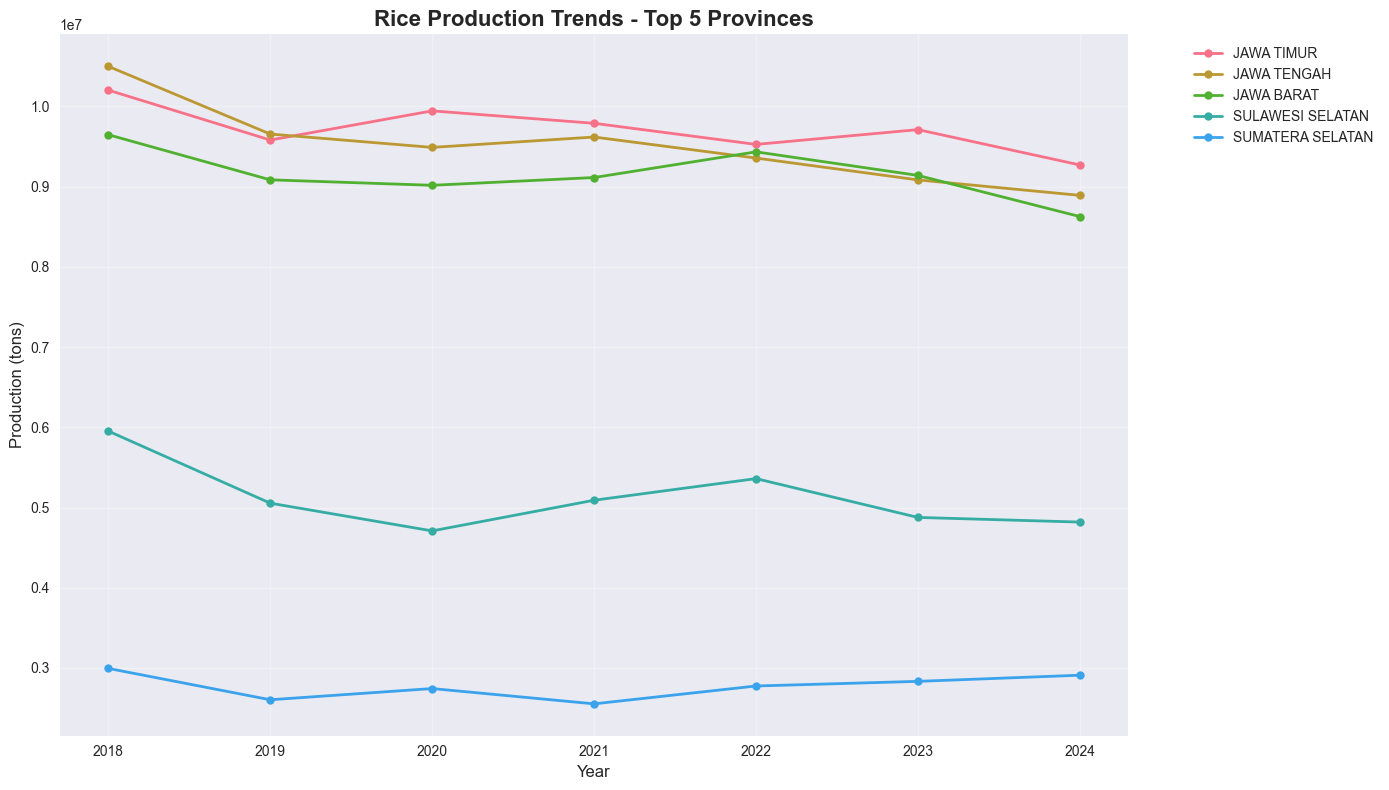


Provincial Production Stability Analysis (Top 15):
           Province  Mean_Production  CV_Production  Trend_Slope  Data_Points
         JAWA TIMUR       9717983.66           3.11   -105603.61            7
        JAWA TENGAH       9513559.03           5.43   -217881.65            7
         JAWA BARAT       9151900.53           3.53    -90511.51            7
   SULAWESI SELATAN       5122981.44           8.27   -110943.53            7
   SUMATERA SELATAN       2772906.51           5.69      8443.72            7
            LAMPUNG       2575125.63           8.43     76200.18            7
     SUMATERA UTARA       2087537.52           2.99     12678.62            7
               ACEH       1648802.07           9.29    -52609.47            7
             BANTEN       1634627.64           6.35      5496.19            7
NUSA TENGGARA BARAT       1434880.16           4.69     13845.46            7
     SUMATERA BARAT       1411859.98           4.94    -14093.48            7
 KALIMANTAN 

In [13]:
# Create provincial time series data
provincial_ts = clean_df.pivot_table(
    index='Year', 
    columns='Province', 
    values=['Luas_Panen_ha', 'Produktivitas_ku_ha', 'Produksi_ton'],
    aggfunc='sum'
)

# Focus on top 5 producing provinces for detailed analysis
top_5_provinces = top_producers.head(5).index.tolist()

# Create production trends for top provinces
plt.figure(figsize=(14, 8))
for province in top_5_provinces:
    province_data = clean_df[clean_df['Province'] == province]
    plt.plot(province_data['Year'], province_data['Produksi_ton'], 
             marker='o', linewidth=2, markersize=6, label=province)

plt.title('Rice Production Trends - Top 5 Provinces', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Production (tons)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate stability metrics for each province
stability_metrics = []
for province in clean_df['Province'].unique():
    province_data = clean_df[clean_df['Province'] == province]['Produksi_ton']
    if len(province_data) >= 5:  # At least 5 years of data
        cv = (province_data.std() / province_data.mean()) * 100  # Coefficient of variation
        trend = np.polyfit(range(len(province_data)), province_data, 1)[0]  # Linear trend
        stability_metrics.append({
            'Province': province,
            'Mean_Production': province_data.mean(),
            'CV_Production': cv,
            'Trend_Slope': trend,
            'Data_Points': len(province_data)
        })

stability_df = pd.DataFrame(stability_metrics)
stability_df = stability_df.sort_values('Mean_Production', ascending=False)

print("\nProvincial Production Stability Analysis (Top 15):")
print(stability_df.head(15).to_string(index=False, float_format='%.2f'))

## 7. Data Export for Forecasting Models

In [14]:
# Create path 
os.makedirs('processed_data', exist_ok=True)

# Create different datasets for various forecasting approaches

# 1. National level time series
national_forecast_data = national_ts[['Year', 'Luas_Panen_ha', 'Produktivitas_ku_ha', 'Produksi_ton']].copy()
national_forecast_data.to_csv('processed_data/national_timeseries.csv', index=False)

# 2. Provincial level data (wide format)
provincial_production = clean_df.pivot(index='Year', columns='Province', values='Produksi_ton')
provincial_production.to_csv('processed_data/provincial_production_wide.csv')

# 3. Complete cleaned dataset (long format)
clean_df.to_csv('processed_data/complete_cleaned_data.csv', index=False)

# 4. Top provinces dataset for focused modeling
top_provinces_data = clean_df[clean_df['Province'].isin(top_5_provinces)].copy()
top_provinces_data.to_csv('processed_data/top_provinces_data.csv', index=False)

# 5. Aggregated features for ML models
ml_features = clean_df.copy()
# Add lag features
ml_features = ml_features.sort_values(['Province', 'Year'])
ml_features['Produksi_lag1'] = ml_features.groupby('Province')['Produksi_ton'].shift(1)
ml_features['Produktivitas_lag1'] = ml_features.groupby('Province')['Produktivitas_ku_ha'].shift(1)
ml_features['Area_lag1'] = ml_features.groupby('Province')['Luas_Panen_ha'].shift(1)

# Add rolling averages
ml_features['Produksi_ma3'] = ml_features.groupby('Province')['Produksi_ton'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
ml_features['Produktivitas_ma3'] = ml_features.groupby('Province')['Produktivitas_ku_ha'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)

ml_features.to_csv('processed_data/ml_features_dataset.csv', index=False)

print("Data exported successfully!")
print("\nExported files:")
print("1. national_timeseries.csv - National level aggregated data")
print("2. provincial_production_wide.csv - Provincial data in wide format")
print("3. complete_cleaned_data.csv - Complete cleaned dataset")
print("4. top_provinces_data.csv - Top 5 producing provinces")
print("5. ml_features_dataset.csv - Dataset with engineered features for ML")

Data exported successfully!

Exported files:
1. national_timeseries.csv - National level aggregated data
2. provincial_production_wide.csv - Provincial data in wide format
3. complete_cleaned_data.csv - Complete cleaned dataset
4. top_provinces_data.csv - Top 5 producing provinces
5. ml_features_dataset.csv - Dataset with engineered features for ML


## 8. Data Summary and Recommendations

In [15]:
# Final data summary
print("=" * 60)
print("DATA PROCESSING SUMMARY")
print("=" * 60)

print(f"\nDATASET OVERVIEW:")
print(f"   • Time Period: {clean_df['Year'].min()} - {clean_df['Year'].max()}")
print(f"   • Number of Provinces: {clean_df['Province'].nunique()}")
print(f"   • Total Records: {len(clean_df):,}")
print(f"   • Data Completeness: {(1 - clean_df.isnull().sum().sum() / (len(clean_df) * len(clean_df.columns))) * 100:.1f}%")

print(f"\nPRODUCTION STATISTICS:")
total_production = clean_df['Produksi_ton'].sum()
avg_annual_production = clean_df.groupby('Year')['Produksi_ton'].sum().mean()
total_area = clean_df['Luas_Panen_ha'].sum()
avg_productivity = clean_df['Produktivitas_ku_ha'].mean()

print(f"   • Total Production (2018-2024): {total_production:,.0f} tons")
print(f"   • Average Annual Production: {avg_annual_production:,.0f} tons")
print(f"   • Total Harvested Area: {total_area:,.0f} hectares")
print(f"   • Average Productivity: {avg_productivity:.2f} ku/ha")

print(f"\nTRENDS ANALYSIS:")
production_trend = np.polyfit(national_ts['Year'], national_ts['Produksi_ton'], 1)[0]
area_trend = np.polyfit(national_ts['Year'], national_ts['Luas_Panen_ha'], 1)[0]
productivity_trend = np.polyfit(national_ts['Year'], national_ts['Produktivitas_ku_ha'], 1)[0]

print(f"   • Production Trend: {'+' if production_trend > 0 else ''}{production_trend:,.0f} tons/year")
print(f"   • Area Trend: {'+' if area_trend > 0 else ''}{area_trend:,.0f} ha/year")
print(f"   • Productivity Trend: {'+' if productivity_trend > 0 else ''}{productivity_trend:.2f} ku/ha/year")

print(f"\nTOP PERFORMERS:")
for i, (province, production) in enumerate(top_producers.head(3).items(), 1):
    print(f"   {i}. {province}: {production:,.0f} tons")

print(f"\nFORECASTING RECOMMENDATIONS:")
print(f"   • Use national_timeseries.csv for aggregate forecasting")
print(f"   • Use top_provinces_data.csv for focused provincial analysis")
print(f"   • Use ml_features_dataset.csv for machine learning models")
print(f"   • Consider seasonal patterns and external factors (weather, policy)")
print(f"   • Monitor provinces with high coefficient of variation for volatility")

print(f"\nDATA QUALITY:")
print(f"   • No missing values in key variables")
print(f"   • No duplicate province-year combinations")
print(f"   • Consistent data structure across all years")
print(f"   • Outliers identified and preserved for analysis")

print("\n" + "=" * 60)
print("Data processing completed successfully!")
print("Ready for forecasting model development.")
print("=" * 60)

DATA PROCESSING SUMMARY

DATASET OVERVIEW:
   • Time Period: 2018 - 2024
   • Number of Provinces: 38
   • Total Records: 246
   • Data Completeness: 100.0%

PRODUCTION STATISTICS:
   • Total Production (2018-2024): 384,741,759 tons
   • Average Annual Production: 54,963,108 tons
   • Total Harvested Area: 73,837,411 hectares
   • Average Productivity: 45.24 ku/ha

TRENDS ANALYSIS:
   • Production Trend: -689,990 tons/year
   • Area Trend: -183,156 ha/year
   • Productivity Trend: +0.16 ku/ha/year

TOP PERFORMERS:
   1. JAWA TIMUR: 68,025,886 tons
   2. JAWA TENGAH: 66,594,913 tons
   3. JAWA BARAT: 64,063,304 tons

FORECASTING RECOMMENDATIONS:
   • Use national_timeseries.csv for aggregate forecasting
   • Use top_provinces_data.csv for focused provincial analysis
   • Use ml_features_dataset.csv for machine learning models
   • Consider seasonal patterns and external factors (weather, policy)
   • Monitor provinces with high coefficient of variation for volatility

DATA QUALITY:
   •